# Simple seismic modeling

The seismic modeling functionality built into *blixt_rp* is very simple, but at the same time powerful.

Here you have the possibility to create 1D and quasi-2D models either from manual input, or using the statistics and depth trends calculated earlier (*run calculation of Sums and Averages.ipynb* and *Calculate depth trends.ipynb*).

So lets see at some of the possibilities.

Import the necessary python scripts, please modify the *working_dir* to the folder path that you have used in earlier notebooks

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

working_dir = 'C:\\Users\\marten\\PycharmProjects\\blixt_rp'

#the following two lines are only necessary when working with local development versions of the code
sys.path.append('C:\\Users\marten\\PycharmProjects\\blixt_rp')
sys.path.append('C:\\Users\\marten\\PycharmProjects\\blixt_utils')

import blixt_utils.io.io as uio
import blixt_utils.utils as bu
import blixt_rp.plotting.plot_logs as rpp
import blixt_rp.core.models as brm
import blixt_utils.misc.wavelets as bumw

We start by creating a very simple 1D model with three layers, and plot the modelled seismic as a function of incidence angle.

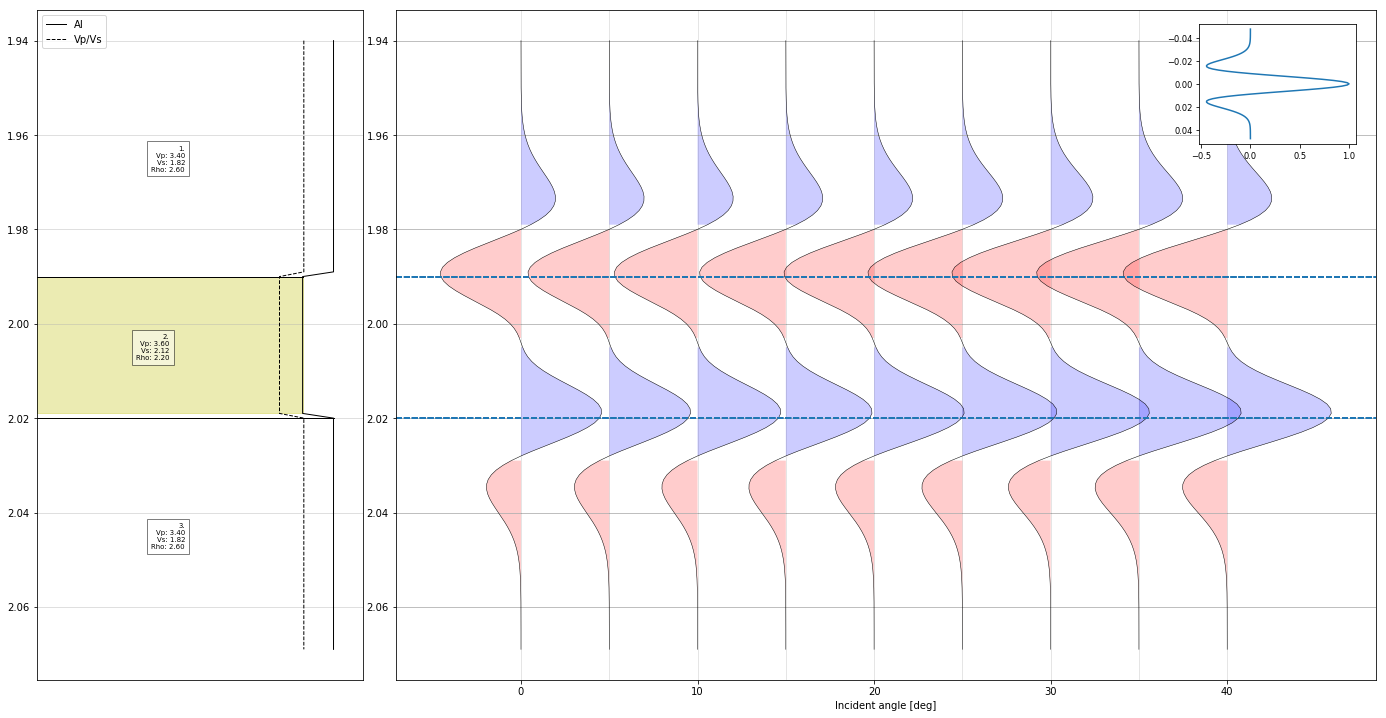

In [3]:
overburden = brm.Layer(thickness=0.05, vp=3400, vs=1820, rho=2.6)
target = brm.Layer(thickness=0.03, vp=3600, vs=2120., rho=2.2, target=True)
m = brm.Model(depth_to_top=1.94, layers=[overburden, target])  # depth_to_top is TWT in seconds
# add a base by appending a copy of the overburden
m.append(overburden)

# and plot the model with incident dependent seismic traces using a 25Hz Ricker wavelet
sample_rate = 0.001
wavelet = bumw.ricker(0.096, sample_rate, 25)
# set up the plot
fig = plt.figure(figsize=(20, 10))
spec = fig.add_gridspec(nrows=1, ncols=2,
                            width_ratios=[1, 3],
                            hspace=0.05, wspace=0.05,
                            left=0.05, bottom=0.03, right=0.98, top=0.96)
ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])
m.plot(ax=ax0)
brm.plot_wiggels(m, sample_rate, wavelet, 
                 avo_angles=[0., 5.,  10. , 15., 20., 25., 30., 35., 40.], 
                 ax=ax1)

We can also plot the Extended Elastic Impedance (EEI) for different Chi angles

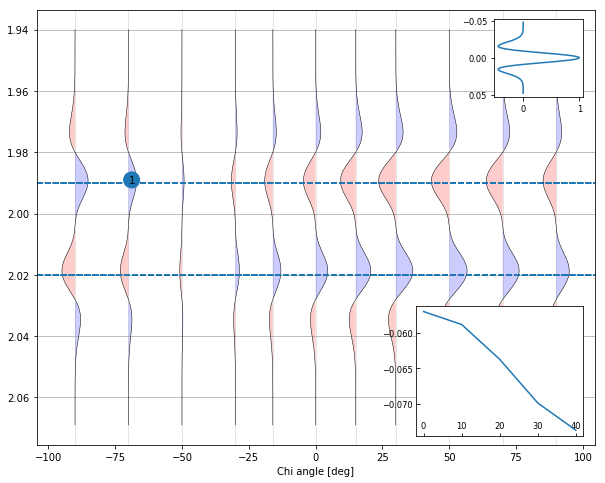

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
brm.plot_wiggels(m, sample_rate, wavelet, 
                 eei=True,
                 avo_angles=[-90., -70.,  -50. , -30., -16., 0., 15., 30., 50., 70., 90.], 
                 extract_avo_at=(-70., 1.99), ax=ax)

The target layer of the model can be modelled using NTG with a thin layer model:

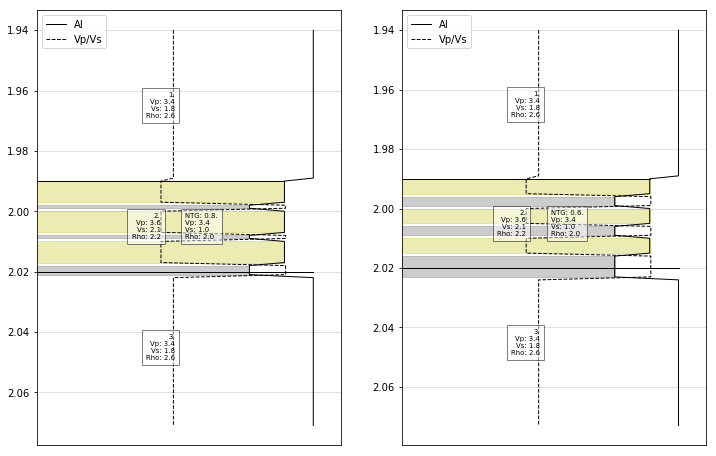

In [4]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 8))
target1 = brm.Layer(thickness=0.03, vp=3600, vs=2120., rho=2.2, ntg=0.8, target=True)
target2 = brm.Layer(thickness=0.03, vp=3600, vs=2120., rho=2.2, ntg=0.6, target=True)
m1 = brm.Model(depth_to_top=1.94, layers=[overburden, target1]) 
m2 = brm.Model(depth_to_top=1.94, layers=[overburden, target2])
m1.append(overburden)
m2.append(overburden)
m1.plot(ax=axs[0])
m2.plot(ax=axs[1])

When calculating the seismic response from such a target, the option *voigt_reuss_hill=True*, in the *realize_model* method, will give a faster and still realistic results when it comes to modeling the effect of various NTG. 

In the examples below, we will use the results from *run calculation of Sums and Averages.ipynb*, which stored averages of the fluid substituted rock properties in *SumsAndAverages_from_python.xlsx*. 

So we begin by reading those results

In [3]:
rokdoc_output=os.path.join(working_dir, 'results_folder', 'SumsAndAverages_from_python.xlsx')
sums = uio.read_sums_and_averages(rokdoc_output)

Now we can build two, quasi-2D, wedge models. One with brine filled target and one with the fluid substituted version of the target.

To create a quasi-2D model, we need an index parametrizing the lateral variation. Lets set it to contain 51 steps 

In [4]:
n_traces = 51
top_layer_thickness = 0.08

for a wedge model to work, we need to counterweight the changing thickness of one layer with an extra layer so that the total height of the model is kept constant

In [5]:
def wedge(i):
    return 0.1 - 0.1/(n_traces-1) * i

def reverse_wedge(i):
    return 0.06 + 0.1/(n_traces-1) * i

And by using these wedges we can build two wedge models; one for the dry (brine) case and one for the fluid substituted (oil) case 

In [6]:
overburden = brm.Layer(
    thickness=top_layer_thickness, 
    vp=sums['Shale C_shale']['VpMedian'],
    vs=sums['Shale C_shale']['VsMedian'],
    rho=sums['Shale C_shale']['RhoMedian'],
)
target_gas = brm.Layer(
    thickness=wedge,    
    vp=sums['Sand D_gas_sand']['VpMedian'],
    vs=sums['Sand D_gas_sand']['VsMedian'],
    rho=sums['Sand D_gas_sand']['RhoMedian'] 
    )
target_dry = brm.Layer(
    thickness=wedge,    
    vp=sums['Sand D_sand']['VpMedian'],
    vs=sums['Sand D_sand']['VsMedian'],
    rho=sums['Sand D_sand']['RhoMedian'] 
    )
base = brm.Layer(
    thickness=reverse_wedge, 
    vp=sums['Shale C_shale']['VpMedian'],
    vs=sums['Shale C_shale']['VsMedian'],
    rho=sums['Shale C_shale']['RhoMedian'],
)             
m_gas = brm.Model(
    depth_to_top=1.4,
    layers=[overburden, target_gas, base],
    trace_index_range=np.arange(n_traces)
)
m_dry = brm.Model(
    depth_to_top=1.4,
    layers=[overburden, target_dry, base],
    trace_index_range=np.arange(n_traces)
) 

First we can have a look at the models at one given trace position

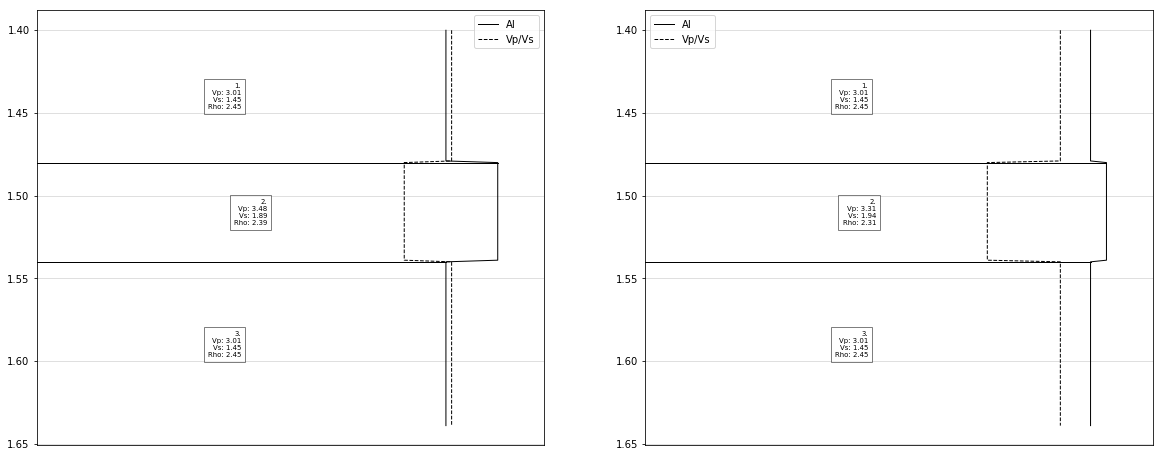

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))
m_dry.plot(axs[0], 20)
m_gas.plot(axs[1], 20)

Now lets plot modelled seismic for the wedge model for vertical incident waves, using the same Ricker wavelet as above

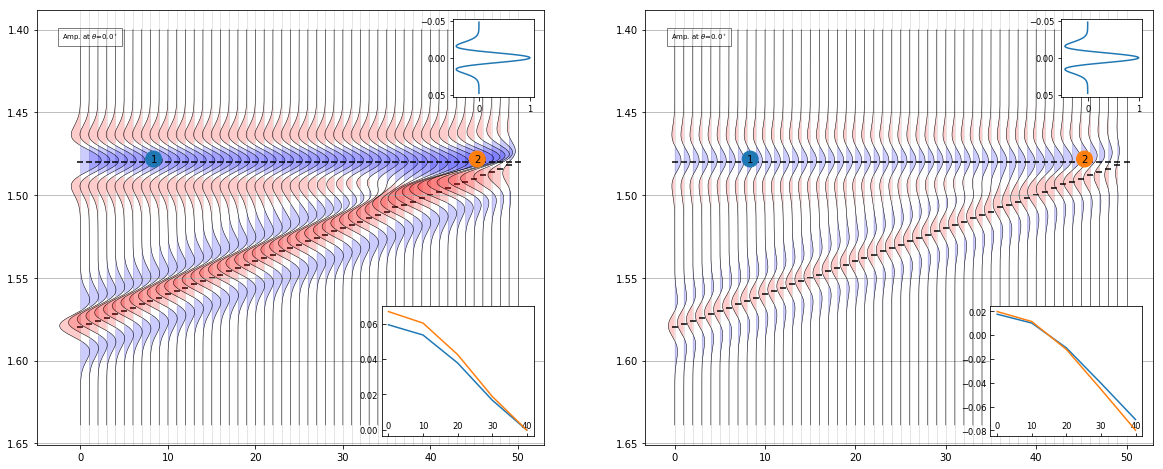

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))
brm.plot_wiggels(m_dry, sample_rate, wavelet, angle=0., eei=False, extract_avo_at=[(8, 1.48), (45, 1.48)], ax=axs[0])
brm.plot_wiggels(m_gas, sample_rate, wavelet, angle=0., eei=False, extract_avo_at=[(8, 1.48), (45, 1.48)], ax=axs[1])

Note that for this particular selection of shale - sand combination, the sand is stiff. The inclusion of gas in the sand dims the response to a AVO class IIP   

## Burial depth
Here we will use the regression results from *Calculate depth trends.pynb*, which is stored in the *Regression* sheet of the project table, and create a quasi 2D model where the quasi 2'nd dimension represents the depth trends of the elastic properties of the rock. 

In [11]:
from blixt_utils.misc.curve_fitting import linear_function
from blixt_rp.core.well import Project

wp = Project(load_from='MyProject_log.txt')

trends = uio.read_regressions(wp.project_table)
print(trends.keys())

dict_keys(['vp_dry', 'vs_dry', 'rho_dry', 'phie', 'vcl'])


Build the quasi 2D model similar as how we built the wedge model, but instead of varying the thickness in the lateral dimension, we change the effective burial depth

In [20]:
n_traces = 51
layer_thickness = 0.08

my_tvd_range = np.linspace(1500., 2000., n_traces)

def vp_shale(_i):
    return linear_function(my_tvd_range[_i], *trends['vp_dry']['All']['Shale C']['Linear']['Params'])
def vs_shale(_i):
    return linear_function(my_tvd_range[_i], *trends['vs_dry']['All']['Shale C']['Linear']['Params'])
def rho_shale(_i):
    return linear_function(my_tvd_range[_i], *trends['rho_dry']['All']['Shale C']['Linear']['Params'])

def vp_sand(_i):
    return linear_function(my_tvd_range[_i], *trends['vp_dry']['All']['Sand H']['Linear']['Params'])
def vs_sand(_i):
    return linear_function(my_tvd_range[_i], *trends['vs_dry']['All']['Sand H']['Linear']['Params'])
def rho_sand(_i):
    return linear_function(my_tvd_range[_i], *trends['rho_dry']['All']['Sand H']['Linear']['Params'])



In [22]:
overburden = brm.Layer(
    thickness=layer_thickness, 
    vp=vp_shale,
    vs=vs_shale,
    rho=rho_shale,
)
sand = brm.Layer(
    thickness=layer_thickness,    
    vp=vp_sand,
    vs=vs_sand,
    rho=rho_sand 
    )

m = brm.Model(
    depth_to_top=1.4,
    layers=[overburden, sand],
    trace_index_range=np.arange(n_traces)
) 
m.append(overburden)

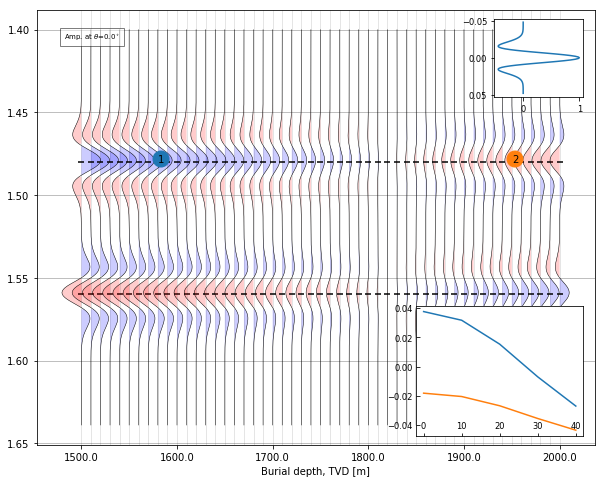

In [53]:
fig, ax = plt.subplots(ncols=1, figsize=(10,8))
brm.plot_wiggels(m, sample_rate, wavelet, angle=0., eei=False, extract_avo_at=[(8, 1.48), (45, 1.48)], ax=ax)
tick_pos = ax.get_xticks()
tick_labels = [''] + [str(my_tvd_range[int(_i)]) for _i in tick_pos[1:-1]] + ['']
ticks = ax.set_xticklabels(tick_labels)
_ = ax.set_xlabel('Burial depth, TVD [m]')

And here we see, as was predicted in *Calculate depth trends.ipynb* that he sand becomes transparent around 1800 m burial depth